# Building Training Sets with Weak Supervision
In this tutorial, we'll build a `Pain-At` relation training set using weakly superivsed methods. This notebook covers: 
- Loading pre-processed documents
- Generating relational candidates 
- Applying labeling functions
- Training a Snorkel Label Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0,'../../ehr-rwe/')

import glob
import collections
import numpy as np
import pandas as pd


## 1. Load MIMIC-III Documents

This notebook assumes documents have already been preprocessed and dumped into JSON format. We created a small annotated dataset using MIMIC-III patient notes. See the `XXXX.ipynb` notebook for instructions on creating the required JSON files 

You will need access to MIMIC-III data to run this notebook using our tutorial annotations.  See https://mimic.physionet.org/gettingstarted/access/

See `preprocessing/README.md` for details.

In [2]:
from rwe import dataloader

inputdir = '/Users/fries/Desktop/foobar/output/'
 
corpus = [
    dataloader([f'{inputdir}/mimic_gold.json']), 
    dataloader([f'{inputdir}/mimic_unlabeled.json'])
]

for split in corpus:
    print(f'Loaded {len(split)} documents')


Loaded 55 documents
Loaded 1322 documents


## 2. Generate Candidates

This is an example pipeline for generating `Pain-At` relation candidates. Relations are defined as a tuple $k$ entity spans. For simplicity's sake, we consider binary relations between all `Anatomy` and `Pain` entity pairs found within the same sentence. Entities can be tagged using a clinical named entity recognition (NER) model if available. Here we use a dictionary-based method to tag our initial `Anatomy` and `Pain` entities. 

### Clinical Text Markup
When writing labeling functions, it's conveinant to have access to document markup and other metadata. For example, we might want to know what document section we are currently in (e.g., Past Medical History) or if we have temporal information above an event, such as a data of occurence, we might want to incorproate that information into our labeling heuristics. 

### Timing Benchmarks 

- 50,000 MIMIC-III documents
- 4 core MacBook Pro 2.5Ghz mid-2015

| N Documents   | N Cores | Time |
|---------------|---------|----------------|
| 299           | 4       | 17 seconds |
| 10,000        | 4       | 4 minutes  |


In [3]:
from rwe.utils import load_dict
from rwe.labelers.taggers import (
    ResetTags, RelationTagger, 
    DictionaryTagger, NegExTagger, HypotheticalTagger, HistoricalTagger,
    SectionHeaderTagger, ParentSectionTagger,
    DocTimeTagger, MappedDocTimeTagger, 
    Timex3Tagger, Timex3NormalizerTagger, TimeDeltaTagger,
)

dict_pain = load_dict('../data/dicts/pain/pain.txt')
dict_anat = load_dict('../data/dicts/anatomy/anat.bz2')

target_entities = ['pain']

# NOTE: Pipelines are *order dependant* as normalizers and attribute taggers assume
# the existence of certain concept targets (e.g., Timex3Normalizer requires timex3 entities)
pipeline = {
    # 1. Clear any previous runs
    "reset"        : ResetTags(),
    
    # 2. Clinical concepts
    "concepts"  : DictionaryTagger({'pain': dict_pain, 'anatomy': dict_anat}),
    "headers"   : SectionHeaderTagger(),
    "timex3"    : Timex3Tagger(),
    
    # 3. Normalize datetimes
    "doctimes"  : DocTimeTagger(prop='CHARTDATE'),
    "normalize" : Timex3NormalizerTagger(),
    
    # 4. Concept attributes
    "section"      : ParentSectionTagger(targets=target_entities),
    "tdelta"       : TimeDeltaTagger(targets=target_entities),
    "negation"     : NegExTagger(targets=target_entities, data_root="../data/dicts/negex/"),
    "hypothetical" : HypotheticalTagger(targets=target_entities),
    'historical'   : HistoricalTagger(targets=target_entities),
    
    # 5. Extract relation candidates
    "pain-at"      : RelationTagger('pain-at', ('pain', 'anatomy'))
}


In [4]:
%%time
from rwe.labelers import TaggerPipelineServer

tagger = TaggerPipelineServer(num_workers=4)
documents = tagger.apply(pipeline, corpus)


auto block size=345
Partitioned into 4 blocks, [342 345] sizes
CPU times: user 2.36 s, sys: 384 ms, total: 2.74 s
Wall time: 1min 3s


In [68]:
from rwe.utils import build_candidate_set

Xs = [
    build_candidate_set(documents[0], "pain-at"),
    build_candidate_set(documents[1], "pain-at")
]


### Load Gold Labeled Data
We have provided gold standard files annotated in BRAT.

In [69]:
from rwe.contrib.brat import *

inputdir = "/Users/fries/Desktop/npj-subset/v2/"

gold = BratAnnotations(inputdir)
gold.annotator_summary()
gold.annotator_agreement(ignore_types=['Concept'], relations_only=True)

ANNOTATOR SUMMARY
-------------------------
jason
-------------------------
ENTITY              962
 - Concept          962
                         
RELATION            182
 - X-at             182
                         
-------------------------
alison
-------------------------
ENTITY              961
 - Concept          961
                         
RELATION            179
 - X-at             179
                         
Kappa Agreement (method=randolph)
OVERALL        (n=539): 0.952
X-at           (n=184): 0.924


In [70]:
# we are only considering pain-at relations for this tutorial, so let's filter the gold data to only pain mentions
annos = gold.aggregate_raters(ignore_types=['Concept'], relations_only=True)

pain_terms = {'pain','tenderness','discomfort','tender', 'painful'}

Ys_brat = {}
relations = [x for x in annos if x.type == 'X-at']
for x in relations:
    if pain_terms.intersection([a.text for a in x.args]):
        # create unique key DOC_NAME, SPANS
        key = tuple([x.doc_name] + sorted([ety.span for ety in x.args]))
        Ys_brat[key] = x
        
print(len(Ys_brat))


146


In [72]:
Ys = []
for x in Xs[0]:
    spans = [
        ((x.pain.abs_char_start, x.pain.abs_char_end + 1),),
        ((x.anatomy.abs_char_start, x.anatomy.abs_char_end + 1),)
    ]
    key = tuple([x.pain.sentence.document.name] + sorted(spans))
    y = 1 if key in Ys_brat else 2
    Ys.append(y)
    
Ys.count(1) # we are missing 6 gold candidates (this impacts our final recall calculation)

140

## 3. Apply Labeling Functions

In [73]:
import re
from rwe.helpers import get_left_span, get_right_span, get_between_span

def dict_matches(span, dictionary):
    matches = []
    toks = span.get_attrib_tokens('words')
    for i in range(len(toks)):
        for j in range(i+1, len(toks)):
            term = ' '.join(toks[i:j]).lower()
            if term in dictionary:
                matches.append(term)
    return matches

ABSTAIN  = 0
NEGATIVE = 2
POSITIVE = 1

neg_rgx = re.compile(
    r'''\b(insensitivity|paresthesias|paresthesia|sensitivity|tenderness|discomfort|heaviness|sensitive|itchiness|tightness|throbbing|numbness|tingling|cramping|coldness|soreness|painful|hurting|itching|burning|tender|buring|aching|hurts|aches|pains|hurt|pain|ache|achy|numb)\b''',
    re.I
)

def LF_is_negated(x):
    return NEGATIVE if 'negated' in x.pain.props else ABSTAIN

def LF_is_hypothetical(x):
    return NEGATIVE if 'hypothetical' in x.pain.props else ABSTAIN

def LF_section_headers(x):
    sections = {
        'past medical history': NEGATIVE,
        'chief complaint': POSITIVE,
        'discharge instructions': NEGATIVE,
        'discharge condition': NEGATIVE
    }
    header = x.pain.props['section'].text.lower() if x.pain.props['section'] else None
    return ABSTAIN if header not in sections else sections[header]

def LF_contiguous_args(x):
    v = not get_between_span(x.pain, x.anatomy)
    v &= not 'negated' in x.pain.props
    v &= not 'hypothetical' in x.pain.props
    return POSITIVE if v else ABSTAIN

def LF_distant_args(x, max_toks=10):
    """Reject candidate if the arguments occur too far apart (in token distance)."""
    span = get_between_span(x.pain, x.anatomy)
    n_toks = len(span.get_attrib_tokens('words')) if span else 0
    return NEGATIVE if n_toks > max_toks else ABSTAIN
    
def LF_between_terms(x):
    """Reject if some key terms occur between arguments."""
    span = get_between_span(x.pain, x.anatomy)
    if not span:
        return ABSTAIN
    # negation term      
    flag = neg_rgx.search(span.text) is not None
    # anatomical term 
    flag |= len(dict_matches(span, dict_anat)) > 0
    return NEGATIVE if flag else ABSTAIN

def LF_complains_of(x):
    rgx = re.compile(r'''\b(complain(s*|ing*) of)\b''', re.I)
    is_negated = 'negated' in x.pain.props
    is_complains_of = rgx.search(get_left_span(x.pain).text, re.I) is not None
    return POSITIVE if not is_negated and is_complains_of else ABSTAIN
    

lfs = [
    LF_is_negated,
    LF_is_hypothetical,
    LF_section_headers,
    LF_contiguous_args,
    LF_distant_args,
    LF_between_terms,
    LF_complains_of
]


In [76]:
%%time
from rwe.labelers import LabelingServer

labeler = LabelingServer(num_workers=4)
Ls = labeler.apply(lfs, Xs)


CPU times: user 1.13 s, sys: 282 ms, total: 1.41 s
Wall time: 3.44 s


In [77]:
from rwe.analysis import lf_summary

lf_summary(Ls[0], Y=Ys, lf_names=[lf.__name__ for lf in lfs])

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_is_negated,0,2,0.155738,0.030055,0.000000,54,3,0.947368
LF_is_hypothetical,1,2,0.010929,0.008197,0.000000,4,0,1.000000
LF_section_headers,2,"[1, 2]",0.240437,0.213115,0.054645,80,8,0.909091
LF_contiguous_args,3,1,0.480874,0.183060,0.054645,124,52,0.704545
LF_distant_args,4,2,0.133880,0.101093,0.000000,49,0,1.000000
LF_between_terms,5,2,0.142077,0.095628,0.002732,52,0,1.000000
LF_complains_of,6,1,0.021858,0.019126,0.002732,5,3,0.625000


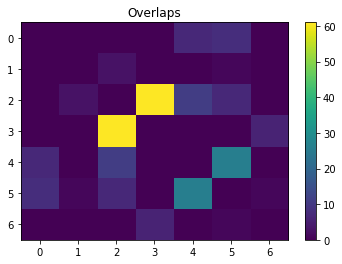

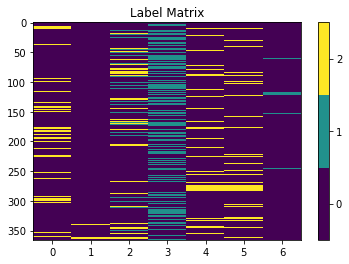

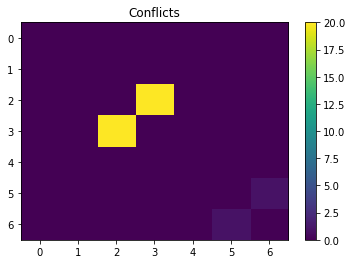

In [78]:
from rwe.visualization.analysis import view_conflicts, view_label_matrix, view_overlaps

view_overlaps(Ls[0], normalize=False)
view_label_matrix(Ls[0])
view_conflicts(Ls[0], normalize=False)

## 4. Train Snorkel Label Model 

In [84]:
# convert sparse matrix to new Snorkel format

def convert_label_matrix(L):
    L = L.toarray().copy()
    L[L == 0] = -1
    L[L == 2] = 0
    return L


Ls_hat = [
    convert_label_matrix(Ls[0]),
    convert_label_matrix(Ls[1]),
]

Ys_hat = [
    np.array([0 if y == 2 else 1 for y in Ys]),
    []
]


In [80]:
from snorkel.labeling import LabelModel

lr = 0.01
l2 = 0.001
prec_init = 0.9

label_model = LabelModel(cardinality=2, device='cpu', verbose=True)
label_model.fit(L_train=Ls_hat[0], 
                n_epochs=1000, 
                lr=lr,
                l2=l2,
                prec_init=prec_init,
                optimizer='adam',
                log_freq=100)

metrics = ['accuracy', 'precision', 'recall', 'f1']
label_model.score(L=Ls_hat[0], Y=Ys_hat[0], metrics=metrics)


{'accuracy': 0.8167202572347267,
 'precision': 0.7039106145251397,
 'recall': 0.9692307692307692,
 'f1': 0.8155339805825242}

## Predict Probabalsitic Labels for Unlabeled Data

In [87]:
#label_model.predict(Ls_hat[1])

label_model.predict_proba(Ls_hat[1])

array([[1.09454077e-04, 9.99890546e-01],
       [9.28945540e-01, 7.10544600e-02],
       [9.96700950e-01, 3.29905027e-03],
       ...,
       [2.53230785e-02, 9.74676922e-01],
       [2.53230785e-02, 9.74676922e-01],
       [2.53230785e-02, 9.74676922e-01]])